In [33]:
from pathlib import Path

import numpy as np
import pandas as pd
from transformers import BertTokenizer
import torch.nn.functional as F
import torch
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import norm, wilcoxon, ttest_ind

In [34]:
MODELS = ['bert-base-multilingual-uncased', 'bert-base-uncased', 'runs/Dec09_01-00-21_elm22', 'runs/Dec09_08-39-08_elm22', 'models/more_loss_improved-epoch-20_aug_data']
target_path = Path('runs') / 'crows_pairs/data/crows_pairs_anonymized.csv'

--- bert-base-multilingual-uncased ---
-31.35603381962865 -31.78448806366048
Ttest_relResult(statistic=-3.769306422117954, pvalue=0.00017001923563099243)
WilcoxonResult(statistic=473787.0, pvalue=1.8752541249851216e-08)
--- bert-base-uncased ---
-26.02256100795756 -26.613938328912468
Ttest_relResult(statistic=-4.377205986556729, pvalue=1.2848758026769643e-05)
WilcoxonResult(statistic=437365.0, pvalue=7.450508167014153e-15)
--- runs/Dec09_01-00-21_elm22 ---
-37.04693103448275 -37.210920424403184
Ttest_relResult(statistic=-1.565124574184582, pvalue=0.11776365134554558)
WilcoxonResult(statistic=501789.0, pvalue=7.26278893683752e-05)
--- runs/Dec09_08-39-08_elm22 ---
-25.704903183023877 -26.214700928381962
Ttest_relResult(statistic=-4.032322736393997, pvalue=5.799030188864147e-05)
WilcoxonResult(statistic=435450.0, pvalue=3.026330113188686e-15)
--- models/more_loss_improved-epoch-20_aug_data ---
-104.79744098143236 -104.79711007957559
Ttest_relResult(statistic=2.157362312289698, pvalue=0.0

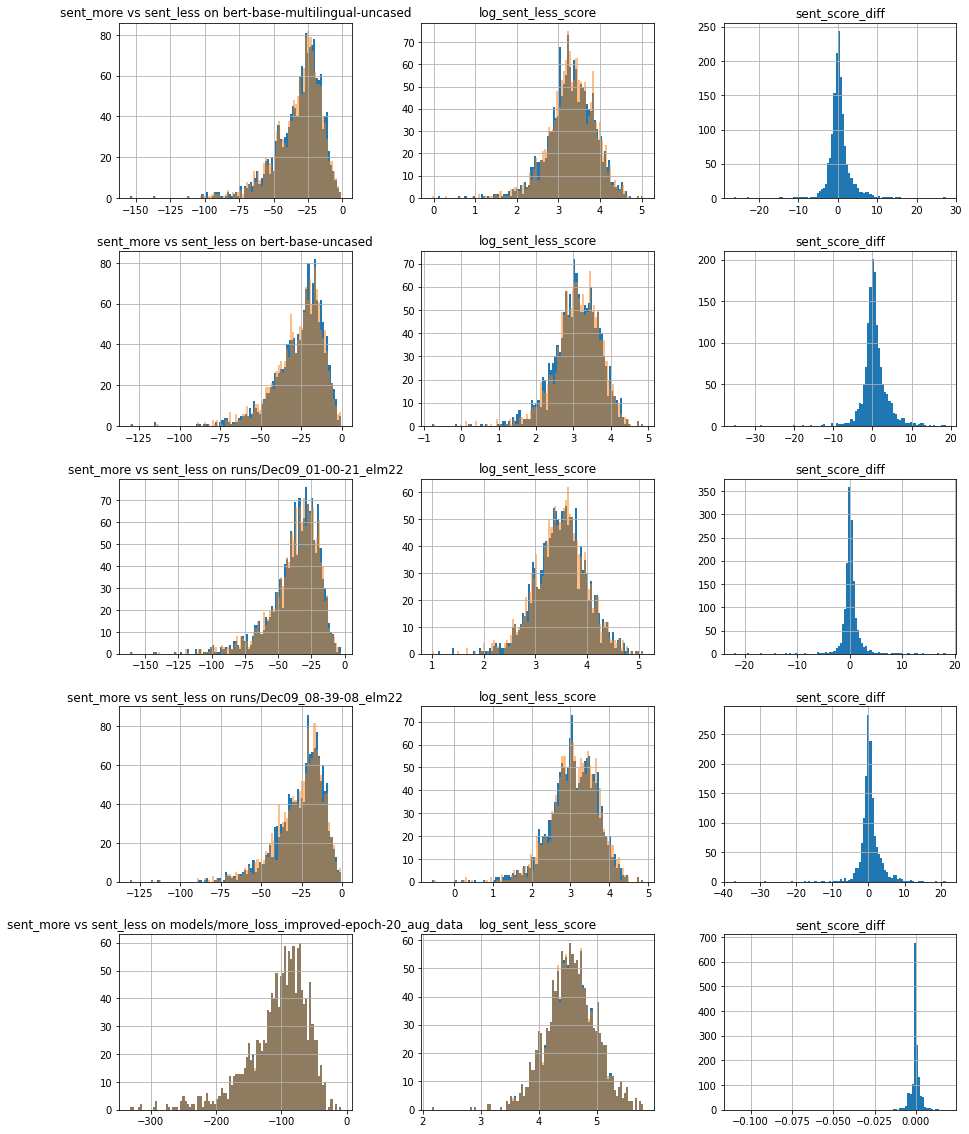

In [35]:
fig, ax = plt.subplots(len(MODELS), 3, figsize=[15.0, 20.0])

# indeces = range(0, 1508)
# indeces = np.random.choice(indeces, 500)

df_dict = {}
for n, model in enumerate(MODELS):
    print(f'--- {model} ---')
    df_dict[model] = pd.read_csv(target_path / model / 'results.csv')
    df = df_dict[model]# .iloc[indeces]
    print(df['sent_more_score'].mean(), df['sent_less_score'].mean())
    df['sent_score_diff'] = df['sent_more_score'] - df['sent_less_score']
    df['log_sent_more_score'] = np.log(-df['sent_more_score'])
    df['log_sent_less_score'] = np.log(-df['sent_less_score'])
    t_result = ttest_rel(df['log_sent_more_score'], df['log_sent_less_score'])
    print(t_result)
    w_result = wilcoxon(df['sent_more_score'], df['sent_less_score'], zero_method='zsplit', correction=True)
    print(w_result)

    count = len(df)
    mn = count * (count + 1.) * 0.25
    se = count * (count + 1.) * (2. * count + 1.)
    t_val = result.statistic / np.sqrt(len(df) - len(df[df['sent_more_score'] == df['sent_less_score']]))

    df.hist('sent_more_score', ax=ax[n][0], bins=100)
    df.hist('sent_less_score', ax=ax[n][0], bins=100, alpha=.5)

    df.hist('log_sent_more_score', ax=ax[n][1], bins=100)
    df.hist('log_sent_less_score', ax=ax[n][1], bins=100, alpha=.5)
    df.hist('sent_score_diff', ax=ax[n][2], bins=100)
    ax[n][0].set_title(f'sent_more vs sent_less on {model}')

# 考察
* 尤度変わりすぎじゃね？（BERT non-ml vs ml, base vs large)に比べても...
  * 割と悪影響している説
     * 元のBERTが出力する尤度から変わらないように制約すべき？